In [1]:
import os
import sys
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score

import random

In [2]:
seed=42

# Code

In [3]:
def create_data(n, noise=False, sigma=0.1):
    # creade set of points at circle with R=1
    phi = 2 * np.pi * np.arange(n) / n    # np.random.rand(n) # np.arange(n) / n
    x, y = np.cos(phi), np.sin(phi)
    if noise:
        x += np.random.normal(0, sigma, n)
        y += np.random.normal(0, sigma, n)
    data = np.hstack((x.reshape(-1, 1), y.reshape(-1, 1)))
    return data

class MyDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __getitem__(self, item):
        return self.data[item]

    def __len__(self):
        return len(self.data)

def single_pass(model, dataloader, loss_func, device, optim=None):
    loss_count = 0
    for i, data in enumerate(dataloader):
        data = data.float().to(device)
        pred = model.forward(data)
        loss = loss_func(pred, data)    ####
        loss_count += loss.item()

        if optim is not None:
            loss.backward()
            optim.step()
            optim.zero_grad()
    return loss_count / len(dataloader)

def train_model(model, loss, optim, epochs, device, datas, print_step=10):
    data_train, data_val = datas
    dataloader_train = DataLoader(MyDataset(data_train), batch_size, shuffle=True)
    dataloader_val = DataLoader(MyDataset(data_val), batch_size, shuffle=True)
    train_loss_all, val_loss_all = [], []
    # training loop
    for epoch in range(epochs):
        # train
        train_loss = single_pass(model, dataloader_train, loss, device, optim)
        
        if epoch % print_step == 0:
            # validation
            with torch.no_grad():
                val_loss = single_pass(model, dataloader_val, loss, device)
            print(
                f'epoch {epoch}, train_loss={train_loss}, val_loss={val_loss}')

            train_loss_all.append(train_loss)
            val_loss_all.append(val_loss)

    return train_loss_all, val_loss_all


In [4]:
def print_examples(model):
    data = create_data(100)
    with torch.no_grad():
        pred = model.forward(torch.tensor(data).float().to(device)).detach().cpu().numpy()
    x, y = data[:, 0], data[:, 1]
    x_pred, y_pred = pred[:, 0], pred[:, 1]

    plt.figure(figsize=(6, 6))
    plt.scatter(x, y, label='true')
    plt.scatter(x_pred, y_pred, label='pred')
    plt.show()

# 2слоя, 16 узлов

In [ ]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(2, 16),
            nn.ReLU(),
            # nn.Linear(64, 64),
            # nn.ReLU(),
            nn.Linear(16, 1),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(1, 16),
            nn.ReLU(),
            # nn.Linear(64, 64),
            # nn.ReLU(),
            nn.Linear(16, 2),
            nn.Tanh()
        )

    def forward(self, x):
        y = self.encoder(x)
        z = self.decoder(y)
        return z

## batch = 8

epoch 0, train_loss=0.29207090119069273, val_loss=0.2509973507661086
epoch 10, train_loss=0.10608210492963818, val_loss=0.0931016870129567
epoch 20, train_loss=0.07837384233293547, val_loss=0.06822071195794986
epoch 30, train_loss=0.09536461313043466, val_loss=0.08680049143731594
epoch 40, train_loss=0.09887290597808632, val_loss=0.08906744621120967
epoch 50, train_loss=0.08790094592338639, val_loss=0.06737080087455419
epoch 60, train_loss=0.05846621907337315, val_loss=0.06612693002590767
epoch 70, train_loss=0.05876795845688321, val_loss=0.06353625798454651
epoch 80, train_loss=0.0750673785594038, val_loss=0.13593664965950525
epoch 90, train_loss=0.06754133476748723, val_loss=0.08719004418414372
epoch 100, train_loss=0.04778904755155302, val_loss=0.045709898337148704
epoch 110, train_loss=0.07910577323160727, val_loss=0.04692101055899492
epoch 120, train_loss=0.04584694381760941, val_loss=0.04047598668302481
epoch 130, train_loss=0.044660235252443024, val_loss=0.053386784749678694
epo

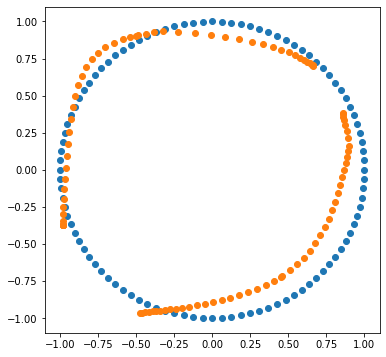

In [ ]:
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

model = AutoEncoder()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

batch_size = 8
epochs = 300
lr = 1e-2
optim = Adam(model.parameters(), lr=lr)
loss = F.mse_loss

# generate data and create data
data_train = create_data(700)
data_val = create_data(100)
datas = [data_train, data_val]

# train model
train_loss, val_loss = train_model(model, loss, optim, epochs, device, datas)

# look at examples
print_examples(model)

## batch = 128


epoch 0, train_loss=0.4396754602591197, val_loss=0.31097710132598877
epoch 10, train_loss=0.23387032002210617, val_loss=0.22844377160072327
epoch 20, train_loss=0.08709479247530301, val_loss=0.0940280556678772
epoch 30, train_loss=0.08856283438702424, val_loss=0.08666198700666428
epoch 40, train_loss=0.07916148131092389, val_loss=0.07678612321615219
epoch 50, train_loss=0.08778011053800583, val_loss=0.09540652483701706
epoch 60, train_loss=0.060389971981445946, val_loss=0.05882536992430687
epoch 70, train_loss=0.05587731239696344, val_loss=0.06356197595596313
epoch 80, train_loss=0.1213423324127992, val_loss=0.10751845687627792
epoch 90, train_loss=0.07215442135930061, val_loss=0.08224745839834213
epoch 100, train_loss=0.05039152813454469, val_loss=0.04300970211625099
epoch 110, train_loss=0.04950686047474543, val_loss=0.041462671011686325
epoch 120, train_loss=0.040689507499337196, val_loss=0.03234197571873665
epoch 130, train_loss=0.06811367596189181, val_loss=0.062435850501060486
ep

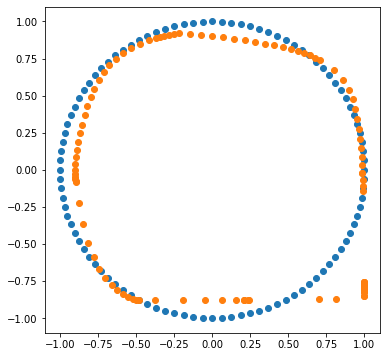

In [ ]:
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

model = AutoEncoder()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

batch_size = 128
epochs = 151
lr = 1e-1
optim = Adam(model.parameters(), lr=lr)
loss = F.mse_loss

# generate data and create dataloaders
data_train = create_data(700)
data_val = create_data(100)
datas = [data_train, data_val]

# train model
train_loss, val_loss = train_model(model, loss, optim, epochs, device, datas)

# look at examples
print_examples(model)

# 2 слоя, 16 узлов, без Tanh

In [ ]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(2, 16),
            nn.ReLU(),
            # nn.Linear(64, 64),
            # nn.ReLU(),
            nn.Linear(16, 1),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(1, 16),
            nn.ReLU(),
            # nn.Linear(64, 64),
            # nn.ReLU(),
            nn.Linear(16, 2),
            # nn.Tanh()
        )

    def forward(self, x):
        y = self.encoder(x)
        z = self.decoder(y)
        return z


print('number of params:', sum(p.numel() for p in AutoEncoder().parameters()))


number of params: 131


## batch = 8

epoch 0, train_loss=0.2916134927760471, val_loss=0.25077299773693085
epoch 10, train_loss=0.11428924660537053, val_loss=0.1107844183078179
epoch 20, train_loss=0.08705124601891095, val_loss=0.08510948345065117
epoch 30, train_loss=0.0794116608608006, val_loss=0.07258473565945259
epoch 40, train_loss=0.06479092564603145, val_loss=0.065283820606195
epoch 50, train_loss=0.07061541422312571, val_loss=0.06451815972104669
epoch 60, train_loss=0.07089584629284218, val_loss=0.06561787358413522
epoch 70, train_loss=0.040388204109727995, val_loss=0.03524501886791908
epoch 80, train_loss=0.038143035942498085, val_loss=0.03707770258188248
epoch 90, train_loss=0.032983735246075827, val_loss=0.04071113750195274
epoch 100, train_loss=0.0356876186190427, val_loss=0.02992427972360299
epoch 110, train_loss=0.030002735258842058, val_loss=0.03545405565259548
epoch 120, train_loss=0.05373458298378286, val_loss=0.05656998715578364
epoch 130, train_loss=0.05290678192184053, val_loss=0.04434740056212132
epoch

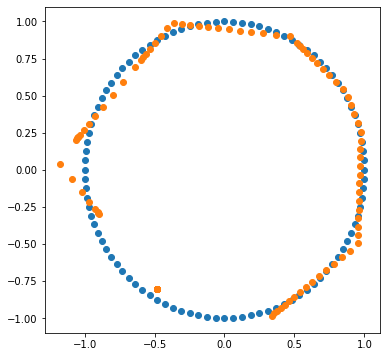

In [ ]:
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

model = AutoEncoder()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

batch_size = 8
epochs = 281
lr = 1e-2
optim = Adam(model.parameters(), lr=lr)
loss = F.mse_loss

# generate data and create data
data_train = create_data(700)
data_val = create_data(100)
datas = [data_train, data_val]

# train model
train_loss, val_loss = train_model(model, loss, optim, epochs, device, datas)

# look at examples
print_examples(model)

## batch = 128

epoch 0, train_loss=0.505521739522616, val_loss=0.4339248538017273
epoch 10, train_loss=0.23787726213534674, val_loss=0.23925843834877014
epoch 20, train_loss=0.1802963688969612, val_loss=0.17752531170845032
epoch 30, train_loss=0.14333439618349075, val_loss=0.14119578897953033
epoch 40, train_loss=0.12083262950181961, val_loss=0.12215310335159302
epoch 50, train_loss=0.10567646597822507, val_loss=0.10951938480138779
epoch 60, train_loss=0.09777332718173663, val_loss=0.09596296399831772
epoch 70, train_loss=0.0890791155397892, val_loss=0.08858567476272583
epoch 80, train_loss=0.07876210597654183, val_loss=0.08179084956645966
epoch 90, train_loss=0.0722117933134238, val_loss=0.07195430994033813
epoch 100, train_loss=0.06671151580909888, val_loss=0.07065649330615997
epoch 110, train_loss=0.06068250288565954, val_loss=0.057626720517873764
epoch 120, train_loss=0.05565637101729711, val_loss=0.054174989461898804
epoch 130, train_loss=0.052936311811208725, val_loss=0.052012745290994644
epoch

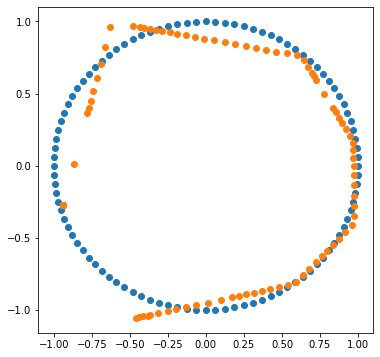

In [ ]:
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

model = AutoEncoder()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

batch_size = 128
epochs = 331
lr = 1e-2
optim = Adam(model.parameters(), lr=lr)
loss = F.mse_loss

# generate data and create data
data_train = create_data(700)
data_val = create_data(100)
datas = [data_train, data_val]

# train model
train_loss, val_loss = train_model(model, loss, optim, epochs, device, datas)

# look at examples
print_examples(model)

# 3 слоя, 6 узлов

In [ ]:
class AutoEncoder(nn.Module):
    def __init__(self, h=6):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(2, h),
            nn.ReLU(),
            nn.Linear(h, h),
            nn.ReLU(),
            nn.Linear(h, 1),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(1, h),
            nn.ReLU(),
            nn.Linear(h, h),
            nn.ReLU(),
            nn.Linear(h, 2),
            nn.Tanh()
        )

    def forward(self, x):
        y = self.encoder(x)
        z = self.decoder(y)
        return z
  
print('number of params:', sum(p.numel() for p in AutoEncoder().parameters()))



number of params: 135


epoch 0, train_loss=0.44209835813804105, val_loss=0.3130351986203875
epoch 10, train_loss=0.25302375040271063, val_loss=0.2420226527111871
epoch 20, train_loss=0.2517371953211047, val_loss=0.23874335416725703
epoch 30, train_loss=0.2497854818674651, val_loss=0.26773043402603697
epoch 40, train_loss=0.24779789691621606, val_loss=0.22574795356818608
epoch 50, train_loss=0.2288258024914698, val_loss=0.21228911301919393
epoch 60, train_loss=0.21530960449440914, val_loss=0.22463469633034297
epoch 70, train_loss=0.20664840428666634, val_loss=0.20434491762093135
epoch 80, train_loss=0.20564373074607414, val_loss=0.19495409301349095
epoch 90, train_loss=0.2055188464847478, val_loss=0.20736008882522583
epoch 100, train_loss=0.20376177233728496, val_loss=0.20146260729857854
epoch 110, train_loss=0.2145830299705267, val_loss=0.24242032638617925
epoch 120, train_loss=0.21179264902391218, val_loss=0.19287667024348462
epoch 130, train_loss=0.20335899801416832, val_loss=0.17918460550052778
epoch 140,

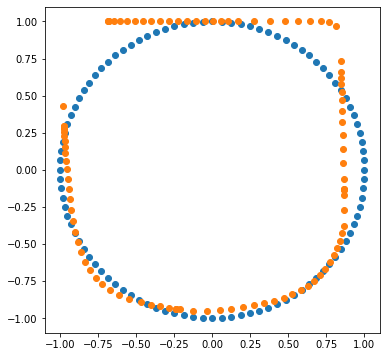

In [ ]:
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

model = AutoEncoder()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

batch_size = 16
epochs = 500
lr = 1e-2
optim = Adam(model.parameters(), lr=lr)
loss = F.mse_loss

# generate data and create data
data_train = create_data(700)
data_val = create_data(100)
datas = [data_train, data_val]

# train model
train_loss, val_loss = train_model(model, loss, optim, epochs, device, datas)

# look at examples
print_examples(model)

epoch 0, train_loss=0.4430141770704226, val_loss=0.31056374540695775
epoch 10, train_loss=0.254504181698642, val_loss=0.24714765869654143
epoch 20, train_loss=0.20079181969843127, val_loss=0.17959453165531158
epoch 30, train_loss=0.111429834399711, val_loss=0.11267727670761254
epoch 40, train_loss=0.07244009352077475, val_loss=0.0630232746211382
epoch 50, train_loss=0.050112863775046375, val_loss=0.04284356724327573
epoch 60, train_loss=0.041023878803984684, val_loss=0.04773471117592775
epoch 70, train_loss=0.04328496407040141, val_loss=0.05050470916411051
epoch 80, train_loss=0.034630190432918345, val_loss=0.028483624426791303
epoch 90, train_loss=0.03468326654348692, val_loss=0.05346381520995727
epoch 100, train_loss=0.02279933033489876, val_loss=0.022678558249026537
epoch 110, train_loss=0.025848347799513827, val_loss=0.03007912402972579
epoch 120, train_loss=0.02366136843656105, val_loss=0.031926812030948125
epoch 130, train_loss=0.027697769342921674, val_loss=0.026018827723769043


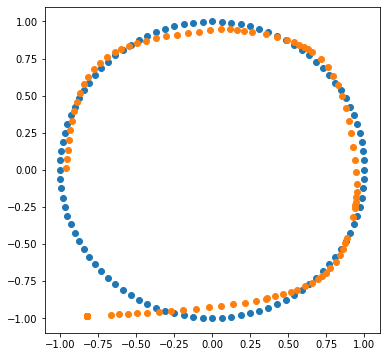

In [ ]:
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

model = AutoEncoder()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

batch_size = 8
epochs = 500
lr = 5*1e-3
optim = Adam(model.parameters(), lr=lr)
loss = F.mse_loss

# generate data and create data
data_train = create_data(700)
data_val = create_data(100)
datas = [data_train, data_val]

# train model
train_loss, val_loss = train_model(model, loss, optim, epochs, device, datas)

# look at examples
print_examples(model)

epoch 0, train_loss=0.4430141770704226, val_loss=0.31056374540695775
epoch 10, train_loss=0.254504181698642, val_loss=0.24714765869654143
epoch 20, train_loss=0.20079181969843127, val_loss=0.17959453165531158
epoch 30, train_loss=0.111429834399711, val_loss=0.11267727670761254
epoch 40, train_loss=0.07244009352077475, val_loss=0.0630232746211382
epoch 50, train_loss=0.050112863775046375, val_loss=0.04284356724327573
epoch 60, train_loss=0.041023878803984684, val_loss=0.04773471117592775
epoch 70, train_loss=0.04328496407040141, val_loss=0.05050470916411051
epoch 80, train_loss=0.034630190432918345, val_loss=0.028483624426791303
epoch 90, train_loss=0.03468326654348692, val_loss=0.05346381520995727
epoch 100, train_loss=0.02279933033489876, val_loss=0.022678558249026537
epoch 110, train_loss=0.025848347799513827, val_loss=0.03007912402972579
epoch 120, train_loss=0.02366136843656105, val_loss=0.031926812030948125
epoch 130, train_loss=0.027697769342921674, val_loss=0.026018827723769043


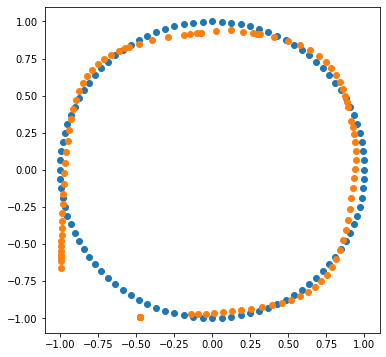

In [ ]:
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

model = AutoEncoder()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

batch_size = 8
epochs = 221
lr = 5*1e-3
optim = Adam(model.parameters(), lr=lr)
loss = F.mse_loss

# generate data and create data
data_train = create_data(700)
data_val = create_data(100)
datas = [data_train, data_val]

# train model
train_loss, val_loss = train_model(model, loss, optim, epochs, device, datas)

# look at examples
print_examples(model)

# 3 слоя, 6 узлов, без Tanh

In [6]:
class AutoEncoder(nn.Module):
    def __init__(self, h=6):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(2, h),
            nn.ReLU(),
            nn.Linear(h, h),
            nn.ReLU(),
            nn.Linear(h, 1),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(1, h),
            nn.ReLU(),
            nn.Linear(h, h),
            nn.ReLU(),
            nn.Linear(h, 2),
            # nn.Tanh()
        )

    def forward(self, x):
        y = self.encoder(x)
        z = self.decoder(y)
        return z
  
print('number of params:', sum(p.numel() for p in AutoEncoder().parameters()))



number of params: 135


## batch = 8 -- BEST! --

epoch 0, train_loss=0.44241256994957273, val_loss=0.3105295025385343
epoch 10, train_loss=0.2528762378814546, val_loss=0.24542557849333838
epoch 20, train_loss=0.19349640125239437, val_loss=0.17644628710471666
epoch 30, train_loss=0.08546757192181592, val_loss=0.09392988595824975
epoch 40, train_loss=0.07447124206969007, val_loss=0.061045992403076246
epoch 50, train_loss=0.0629158893134445, val_loss=0.08340941956983162
epoch 60, train_loss=0.05062492993998934, val_loss=0.048229770305065006
epoch 70, train_loss=0.045903917465528306, val_loss=0.04558507911860943
epoch 80, train_loss=0.0356449244692075, val_loss=0.03973182691977574
epoch 90, train_loss=0.027418190317059107, val_loss=0.029342731460928917
epoch 100, train_loss=0.03650248337494717, val_loss=0.04069007488970573
epoch 110, train_loss=0.03283389321189712, val_loss=0.021806016206168212
epoch 120, train_loss=0.043528519083999774, val_loss=0.024319983051659968
epoch 130, train_loss=0.032561841918240214, val_loss=0.0207474867168527

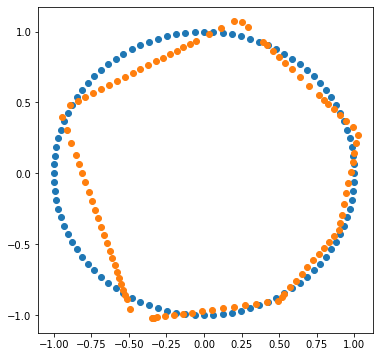

In [7]:
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

model = AutoEncoder()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

batch_size = 8
epochs = 500
lr = 5*1e-3
optim = Adam(model.parameters(), lr=lr)
loss = F.mse_loss

# generate data and create data
data_train = create_data(700)
data_val = create_data(100)
datas = [data_train, data_val]

# train model
train_loss, val_loss = train_model(model, loss, optim, epochs, device, datas)

# look at examples
print_examples(model)

epoch 0, train_loss=0.44241256994957273, val_loss=0.3105295025385343
epoch 10, train_loss=0.2528762378814546, val_loss=0.24542557849333838
epoch 20, train_loss=0.19349640125239437, val_loss=0.17644628710471666
epoch 30, train_loss=0.08546757192181592, val_loss=0.09392988595824975
epoch 40, train_loss=0.07447124206969007, val_loss=0.061045992403076246
epoch 50, train_loss=0.0629158893134445, val_loss=0.08340941956983162
epoch 60, train_loss=0.05062492993998934, val_loss=0.048229770305065006
epoch 70, train_loss=0.045903917465528306, val_loss=0.04558507911860943
epoch 80, train_loss=0.0356449244692075, val_loss=0.03973182691977574
epoch 90, train_loss=0.027418190317059107, val_loss=0.029342731460928917
epoch 100, train_loss=0.03650248337494717, val_loss=0.04069007488970573
epoch 110, train_loss=0.03283389321189712, val_loss=0.021806016206168212
epoch 120, train_loss=0.043528519083999774, val_loss=0.024319983051659968
epoch 130, train_loss=0.032561841918240214, val_loss=0.0207474867168527

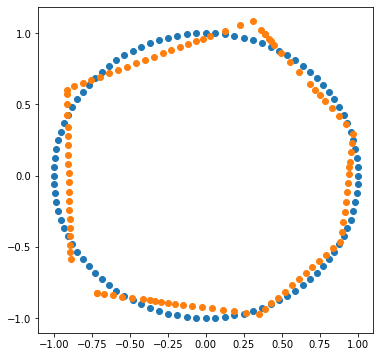

In [ ]:
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

model = AutoEncoder()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

batch_size = 8
epochs = 600
lr = 5*1e-3
optim = Adam(model.parameters(), lr=lr)
loss = F.mse_loss

# generate data and create data
data_train = create_data(700)
data_val = create_data(100)
datas = [data_train, data_val]

# train model
train_loss, val_loss = train_model(model, loss, optim, epochs, device, datas)

# look at examples
print_examples(model)

epoch 0, train_loss=0.44241256994957273, val_loss=0.3105295025385343
epoch 50, train_loss=0.06689345601692119, val_loss=0.056792099888508134
epoch 100, train_loss=0.030034314819865605, val_loss=0.025867619193517245
epoch 150, train_loss=0.03669253798117014, val_loss=0.03425478505400511
epoch 200, train_loss=0.026373329223133624, val_loss=0.021528601718063537
epoch 250, train_loss=0.04639576672872698, val_loss=0.04869793240840618
epoch 300, train_loss=0.030754595825617962, val_loss=0.03026114970159072
epoch 350, train_loss=0.031695740842472085, val_loss=0.022321118543354366
epoch 400, train_loss=0.025193036830222063, val_loss=0.018891249460956223
epoch 450, train_loss=0.024774815982461652, val_loss=0.013600142350277076
epoch 500, train_loss=0.009795810672750866, val_loss=0.010159067469290815
epoch 550, train_loss=0.010150000618357974, val_loss=0.007835218145583685
epoch 600, train_loss=0.025409669234332712, val_loss=0.00954277877910779
epoch 650, train_loss=0.0041419687080302865, val_lo

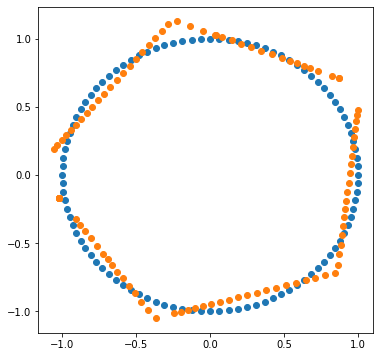

In [ ]:
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

model = AutoEncoder()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

batch_size = 8
epochs = 751
lr = 5*1e-3
optim = Adam(model.parameters(), lr=lr)
loss = F.mse_loss

# generate data and create data
data_train = create_data(700)
data_val = create_data(100)
datas = [data_train, data_val]

# train model
train_loss, val_loss = train_model(model, loss, optim, epochs, device, datas, print_step=50)

# look at examples
print_examples(model)

## batch = 64

epoch 0, train_loss=0.5286621803587134, val_loss=0.5136855244636536
epoch 10, train_loss=0.2657722112807361, val_loss=0.25983262807130814
epoch 20, train_loss=0.2527668056162921, val_loss=0.2533899396657944
epoch 30, train_loss=0.2512038160454143, val_loss=0.25460314005613327
epoch 40, train_loss=0.24946410953998566, val_loss=0.24676463752985
epoch 50, train_loss=0.24817000329494476, val_loss=0.2473502978682518
epoch 60, train_loss=0.2400601248849522, val_loss=0.2375689223408699
epoch 70, train_loss=0.17175774073058908, val_loss=0.17289235442876816
epoch 80, train_loss=0.11855617707425897, val_loss=0.10671824961900711
epoch 90, train_loss=0.09028954871676186, val_loss=0.0824047327041626
epoch 100, train_loss=0.08042181926694783, val_loss=0.07302693091332912
epoch 110, train_loss=0.0712599828839302, val_loss=0.06601994670927525
epoch 120, train_loss=0.0694622929123315, val_loss=0.0698331892490387
epoch 130, train_loss=0.06340004876255989, val_loss=0.07154328934848309
epoch 140, train_lo

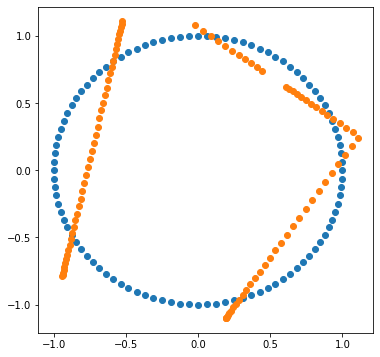

In [ ]:
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

model = AutoEncoder()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

batch_size = 64
epochs = 500
lr = 5*1e-3
optim = Adam(model.parameters(), lr=lr)
loss = F.mse_loss

# generate data and create data
data_train = create_data(700)
data_val = create_data(100)
datas = [data_train, data_val]

# train model
train_loss, val_loss = train_model(model, loss, optim, epochs, device, datas)

# look at examples
print_examples(model)

# 4 слоя, 4 узла

In [ ]:
class AutoEncoder(nn.Module):
    def __init__(self, h=4):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(2, h),
            nn.ReLU(),
            nn.Linear(h, h),
            nn.ReLU(),
            nn.Linear(h, h),
            nn.ReLU(),
            nn.Linear(h, 1),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(1, h),
            nn.ReLU(),
            nn.Linear(h, h),
            nn.ReLU(),
            nn.Linear(h, h),
            nn.ReLU(),
            nn.Linear(h, 2),
            nn.Tanh()
        )

    def forward(self, x):
        y = self.encoder(x)
        z = self.decoder(y)
        return z
  
print('number of params:', sum(p.numel() for p in AutoEncoder().parameters()))



number of params: 115


## batch = 8

epoch 0, train_loss=0.6392049460925839, val_loss=0.5978148029400752
epoch 10, train_loss=0.26408226703378285, val_loss=0.2623656288935588
epoch 20, train_loss=0.20653963088989258, val_loss=0.19934615779381532
epoch 30, train_loss=0.11914359020407904, val_loss=0.12211218390327233
epoch 40, train_loss=0.09144990601238202, val_loss=0.08924028786042562
epoch 50, train_loss=0.07922543867872181, val_loss=0.07532799508995734
epoch 60, train_loss=0.07032683781686831, val_loss=0.07050309330224991
epoch 70, train_loss=0.061803511359771204, val_loss=0.05806819578775993
epoch 80, train_loss=0.05649875322176905, val_loss=0.0511726073634166
epoch 90, train_loss=0.051061263773590326, val_loss=0.05201715947343753
epoch 100, train_loss=0.04920152168911458, val_loss=0.053020415970912345
epoch 110, train_loss=0.045722125706643885, val_loss=0.04178040703901878
epoch 120, train_loss=0.04701270983258093, val_loss=0.04303683419353687
epoch 130, train_loss=0.04166061808460985, val_loss=0.0420641631890948
epoc

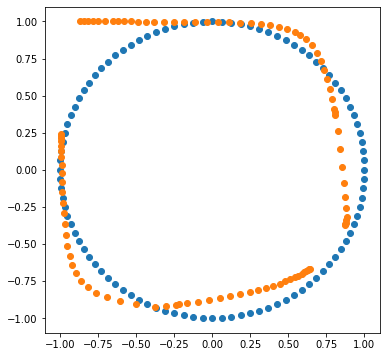

In [ ]:
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

model = AutoEncoder()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

batch_size = 8
epochs = 500
lr = 1e-3
optim = Adam(model.parameters(), lr=lr)
loss = F.mse_loss

# generate data and create data
data_train = create_data(700)
data_val = create_data(100)
datas = [data_train, data_val]

# train model
train_loss, val_loss = train_model(model, loss, optim, epochs, device, datas)

# look at examples
print_examples(model)

## batch = 32

epoch 0, train_loss=0.6762341775677421, val_loss=0.6539255380630493
epoch 10, train_loss=0.49915810200301086, val_loss=0.4869685173034668
epoch 20, train_loss=0.2996074042536996, val_loss=0.2904887869954109
epoch 30, train_loss=0.27725779942490836, val_loss=0.27384572103619576
epoch 40, train_loss=0.2677874510938471, val_loss=0.2906944490969181
epoch 50, train_loss=0.2600982534614476, val_loss=0.25817716866731644
epoch 60, train_loss=0.2542130134322427, val_loss=0.25939832627773285
epoch 70, train_loss=0.25053011016412213, val_loss=0.26922454684972763
epoch 80, train_loss=0.2432046654549512, val_loss=0.23387688770890236
epoch 90, train_loss=0.22290526465936142, val_loss=0.17991504818201065
epoch 100, train_loss=0.19490359655835413, val_loss=0.19176830351352692
epoch 110, train_loss=0.16596891798756339, val_loss=0.15867853164672852
epoch 120, train_loss=0.14730416814034636, val_loss=0.15260461531579494
epoch 130, train_loss=0.12922434982928363, val_loss=0.11134132463485003
epoch 140, tr

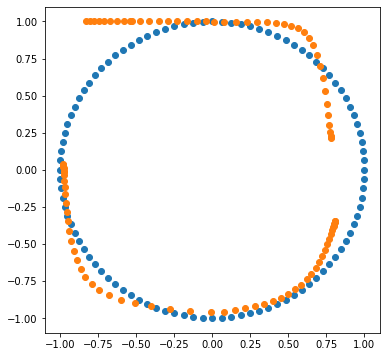

In [ ]:
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

model = AutoEncoder()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

batch_size = 32
epochs = 500
lr = 1e-3
optim = Adam(model.parameters(), lr=lr)
loss = F.mse_loss

# generate data and create data
data_train = create_data(700)
data_val = create_data(100)
datas = [data_train, data_val]

# train model
train_loss, val_loss = train_model(model, loss, optim, epochs, device, datas)

# look at examples
print_examples(model)

# 4 слоя, 4 узла, без Tanh

In [ ]:
class AutoEncoder(nn.Module):
    def __init__(self, h=4):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(2, h),
            nn.ReLU(),
            nn.Linear(h, h),
            nn.ReLU(),
            nn.Linear(h, h),
            nn.ReLU(),
            nn.Linear(h, 1),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(1, h),
            nn.ReLU(),
            nn.Linear(h, h),
            nn.ReLU(),
            nn.Linear(h, h),
            nn.ReLU(),
            nn.Linear(h, 2),
            # nn.Tanh()
        )

    def forward(self, x):
        y = self.encoder(x)
        z = self.decoder(y)
        return z
  
print('number of params:', sum(p.numel() for p in AutoEncoder().parameters()))



number of params: 115


## batch = 8

epoch 0, train_loss=0.6586351922967217, val_loss=0.6077469037129328
epoch 10, train_loss=0.2710537417707118, val_loss=0.2700568414651431
epoch 20, train_loss=0.25097781098024413, val_loss=0.24977171191802391
epoch 30, train_loss=0.23568556991151787, val_loss=0.23219878341142947
epoch 40, train_loss=0.16615169986405157, val_loss=0.1750671496758094
epoch 50, train_loss=0.1201214265416969, val_loss=0.1154574416577816
epoch 60, train_loss=0.07964164124463093, val_loss=0.07633860867757064
epoch 70, train_loss=0.06242069917392324, val_loss=0.061196695655011214
epoch 80, train_loss=0.050422110319645566, val_loss=0.049063993331331476
epoch 90, train_loss=0.04345669571987607, val_loss=0.04062893556860777
epoch 100, train_loss=0.03767820168551142, val_loss=0.0357578109519986
epoch 110, train_loss=0.03435889883390204, val_loss=0.02419726736843586
epoch 120, train_loss=0.03329522586004301, val_loss=0.02693525214607899
epoch 130, train_loss=0.031599897679618814, val_loss=0.02062954266483967
epoch 1

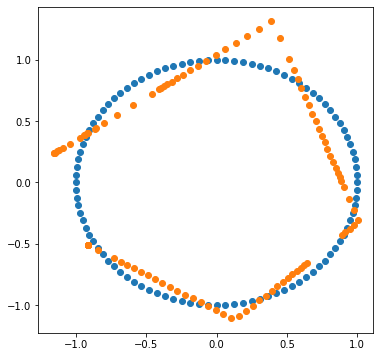

In [ ]:
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

model = AutoEncoder()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

batch_size = 8
epochs = 500
lr = 1e-3
optim = Adam(model.parameters(), lr=lr)
loss = F.mse_loss

# generate data and create data
data_train = create_data(700)
data_val = create_data(100)
datas = [data_train, data_val]

# train model
train_loss, val_loss = train_model(model, loss, optim, epochs, device, datas)

# look at examples
print_examples(model)

## batch = 128

epoch 0, train_loss=0.7279653946558634, val_loss=0.7143728137016296
epoch 10, train_loss=0.6138465702533722, val_loss=0.6239591240882874
epoch 20, train_loss=0.582773874203364, val_loss=0.5830981731414795
epoch 30, train_loss=0.5501862565676371, val_loss=0.5472460985183716
epoch 40, train_loss=0.44319509466489154, val_loss=0.4336329996585846
epoch 50, train_loss=0.36371466020743054, val_loss=0.3588609993457794
epoch 60, train_loss=0.3272937734921773, val_loss=0.32637420296669006
epoch 70, train_loss=0.30694449444611865, val_loss=0.30554550886154175
epoch 80, train_loss=0.29405809938907623, val_loss=0.2919348478317261
epoch 90, train_loss=0.28502323230107623, val_loss=0.2830705940723419
epoch 100, train_loss=0.2763308932383855, val_loss=0.2768136262893677
epoch 110, train_loss=0.2697267681360245, val_loss=0.2720967233181
epoch 120, train_loss=0.2672780106465022, val_loss=0.2683718800544739
epoch 130, train_loss=0.26716365168492, val_loss=0.26528307795524597
epoch 140, train_loss=0.26041

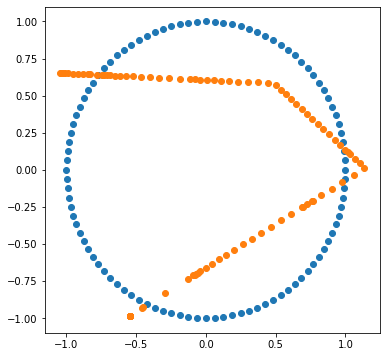

In [ ]:
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

model = AutoEncoder()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

batch_size = 128
epochs = 500
lr = 1e-3
optim = Adam(model.parameters(), lr=lr)
loss = F.mse_loss

# generate data and create data
data_train = create_data(700)
data_val = create_data(100)
datas = [data_train, data_val]

# train model
train_loss, val_loss = train_model(model, loss, optim, epochs, device, datas)

# look at examples
print_examples(model)

# 5 слоев, 4 узла

In [ ]:
class AutoEncoder(nn.Module):
    def __init__(self, h=4):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(2, h),
            nn.ReLU(),
            nn.Linear(h, h),
            nn.ReLU(),
            nn.Linear(h, h),
            nn.ReLU(),
            nn.Linear(h, h),
            nn.ReLU(),
            nn.Linear(h, 1),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(1, h),
            nn.ReLU(),
            nn.Linear(h, h),
            nn.ReLU(),
            nn.Linear(h, h),
            nn.ReLU(),
            nn.Linear(h, h),
            nn.ReLU(),
            nn.Linear(h, 2),
            # nn.Tanh()
        )

    def forward(self, x):
        y = self.encoder(x)
        z = self.decoder(y)
        return z
  
print('number of params:', sum(p.numel() for p in AutoEncoder().parameters()))



number of params: 155


batch = 16

epoch 0, train_loss=0.6367391399920933, val_loss=0.6393535307475499
epoch 10, train_loss=0.500333877782973, val_loss=0.5004834873335702
epoch 20, train_loss=0.5003048380215963, val_loss=0.5000821479729244
epoch 30, train_loss=0.5003334298020318, val_loss=0.49999092732157024
epoch 40, train_loss=0.5001503380518111, val_loss=0.5003974650587354
epoch 50, train_loss=0.5002646942933401, val_loss=0.49986338189670015
epoch 60, train_loss=0.5002754046803429, val_loss=0.5000048492635999
epoch 70, train_loss=0.5002495812045203, val_loss=0.4999828594071524
epoch 80, train_loss=0.5002735465291946, val_loss=0.5002439532961164
epoch 90, train_loss=0.5002222529479435, val_loss=0.500030483518328


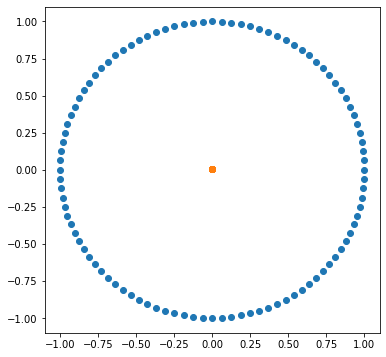

In [ ]:
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

model = AutoEncoder()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

batch_size = 16
epochs = 100
lr = 1e-3
optim = Adam(model.parameters(), lr=lr)
loss = F.mse_loss

# generate data and create data
data_train = create_data(1000)
data_val = create_data(100)
datas = [data_train, data_val]

# train model
train_loss, val_loss = train_model(model, loss, optim, epochs, device, datas)

# look at examples
print_examples(model)